In [ ]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as adefc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm
# import adefc_vortex.scoob_interface as scoobi

# import purepyindi
# from purepyindi import INDIClient
# import purepyindi2
# from purepyindi2 import IndiClient
# client0 = INDIClient('localhost', 7624)
# client0.start()
# client = IndiClient()
# client.connect()
# client.get_properties()


wavelength_c = 633e-9
npix = 1000


In [5]:
scoobi.home_block(client0)

In [7]:
scoobi.move_block_out(client0)

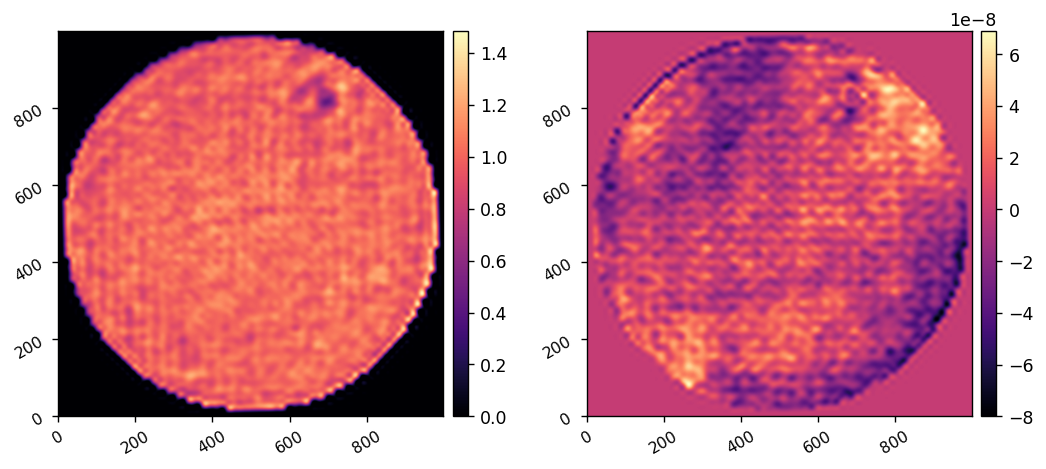

In [6]:
wfe_amp = xp.array(fits.getdata('data/pr_est_amp.fits'))
wfe_opd = xp.array(fits.getdata('data/pr_est_opd.fits'))
WFE = wfe_amp * xp.exp(1j* 2*np.pi/wavelength_c * wfe_opd)
imshow2(wfe_amp, wfe_opd)

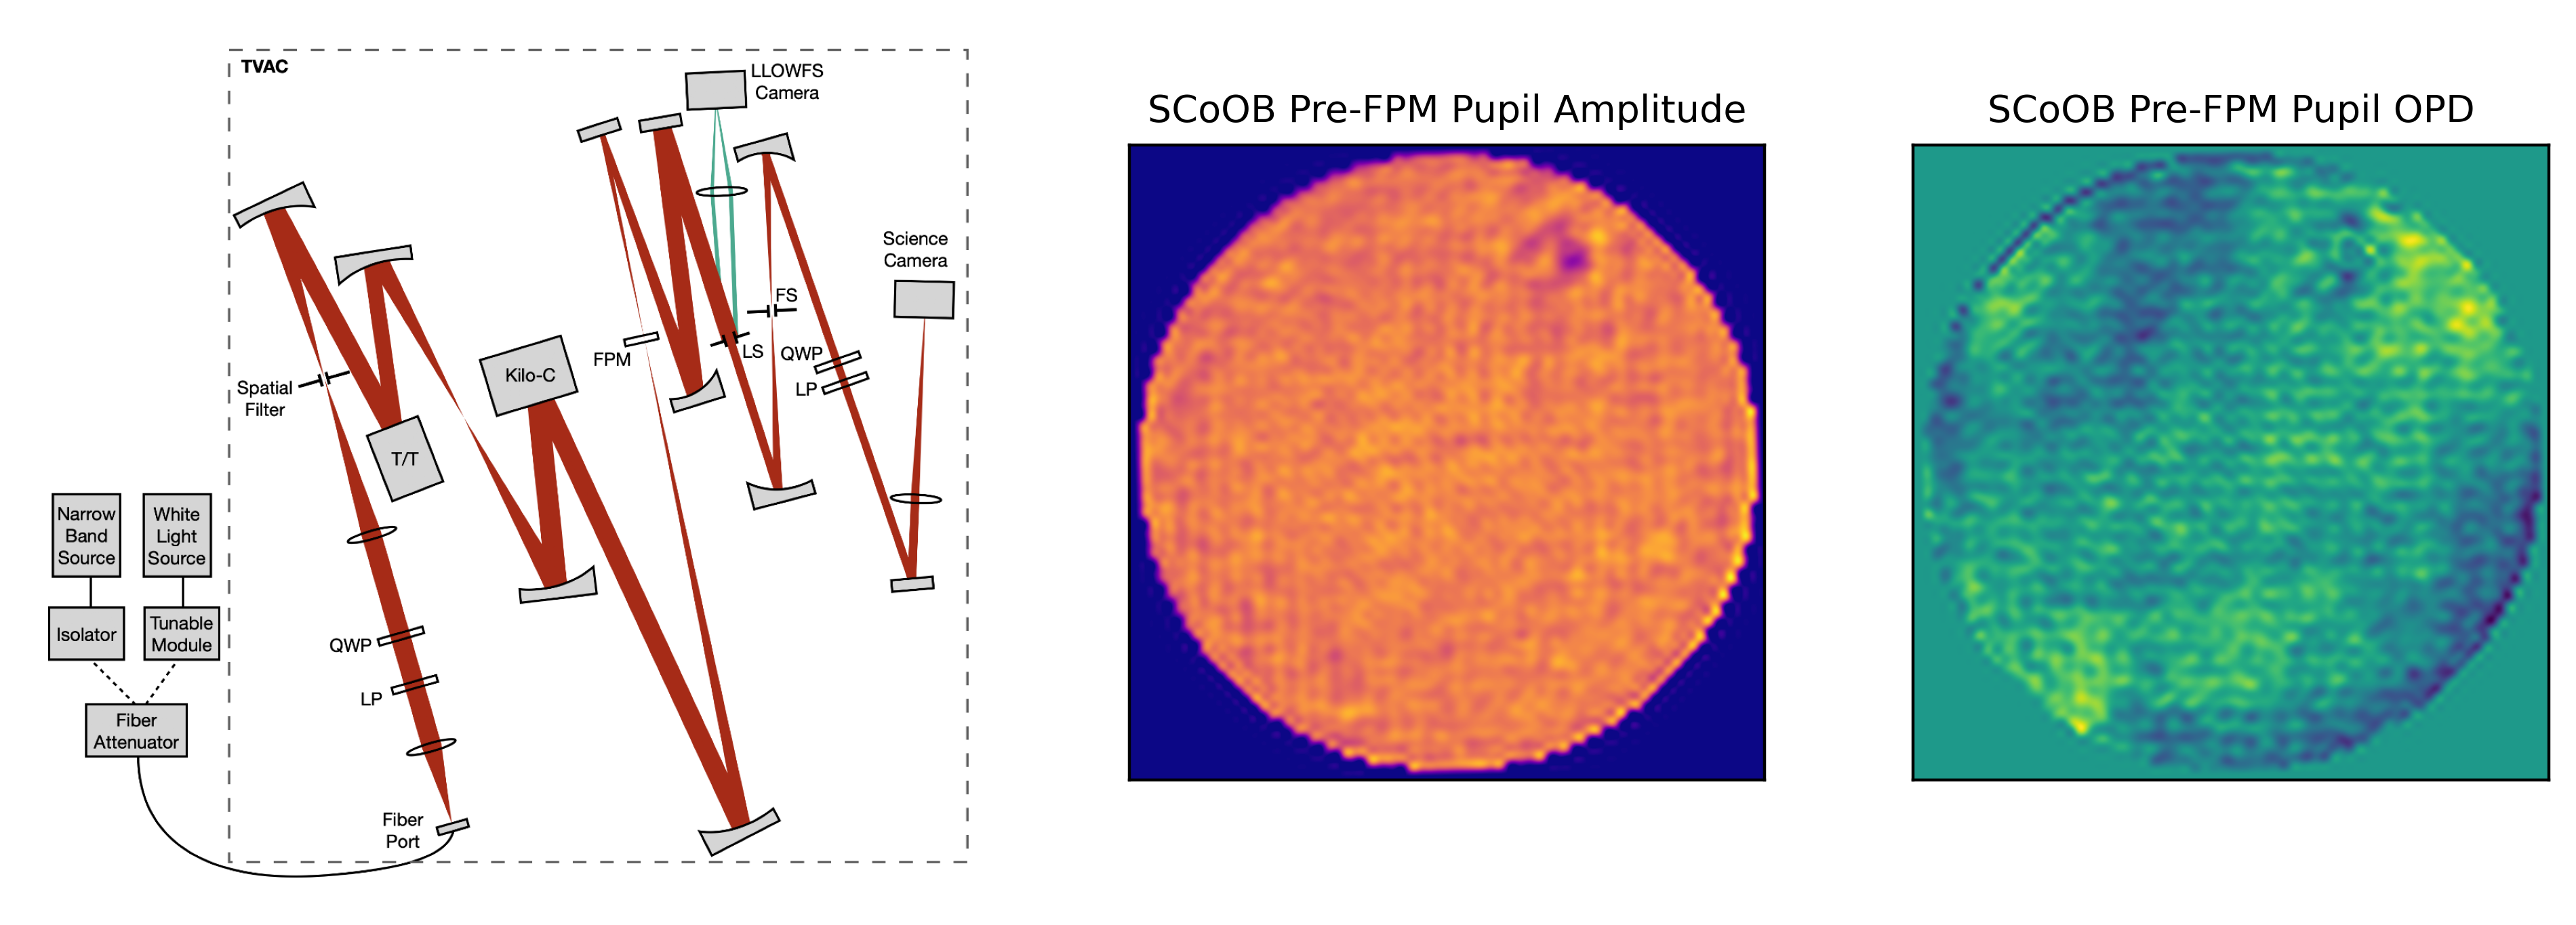

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['image.origin']='lower'
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
# Read the image
img = np.flipud(mpimg.imread('scoob_diagram.png'))

# Display the image
fig, ax = plt.subplots(nrows=1, ncols=3, dpi=400, figsize=(12,6), gridspec_kw={'width_ratios': [1.5, 1, 1], })
ax[0].imshow(img)
ax[0].axis('off')  # Turn off axis labels and ticks

tfs = 10

ax[1].imshow( ensure_np_array(wfe_amp), cmap='plasma')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('SCoOB Pre-FPM Pupil Amplitude', fontsize=tfs)

ax[2].imshow( ensure_np_array(wfe_opd), cmap='viridis')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('SCoOB Pre-FPM Pupil OPD', fontsize=tfs)

# fig.savefig('../figs/scoob_diagram_and_pr.pdf', format='pdf', bbox_inches="tight")

In [6]:
reload(scoobi)
xc, yc = (4780, 3580)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [9]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [14]:
scoobi.move_psf(50, 0, client0)

In [21]:
reload(scoobi)
I.set_zwo_exp_time(0.00050, client0)

Set the ZWO exposure time to 5.00e-04s


In [16]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [22]:
reload(scoobi)
I.set_fib_atten(25, client)

Set the fiber attenuation to 25.0


INFO:utils:Got semaphore index 1.


41238.42


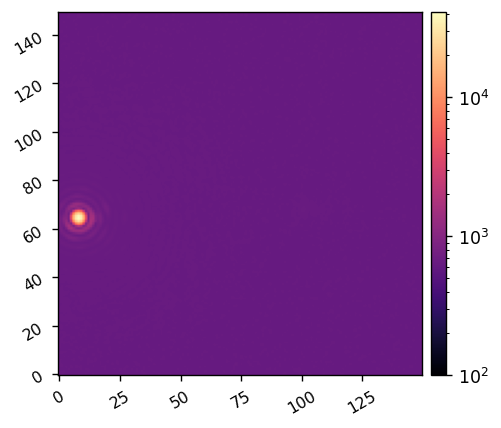

In [23]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [24]:
# I.ref_psf_params = {
#     'ref_psf':copy.copy(ref_psf),
#     'Imax': copy.copy(xp.max(ref_psf)),
#     'texp': copy.copy(I.texp), 
#     'atten': copy.copy(I.atten),
#     'gain': copy.copy(I.gain),
# }
# utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)

I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

Saved data to:  data/20241029_ref_psf_params.pkl


In [60]:
scoobi.move_psf(1, 0, client0)


In [62]:
scoobi.move_psf(0, -1, client0)

In [29]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [108]:
I.set_zwo_exp_time(0.05, client0)

Set the ZWO exposure time to 5.00e-02s


In [63]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [109]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  data/20241029_camsci_dark_frame.fits


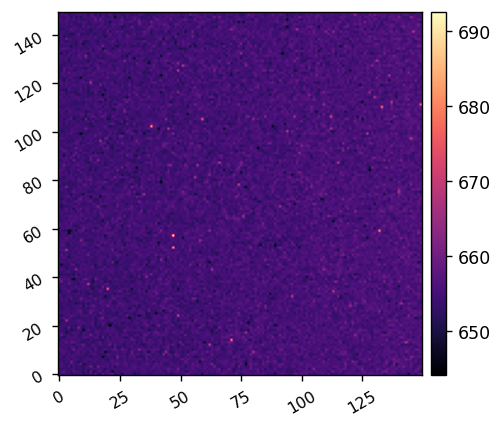

In [110]:
I.NSCICAM = 200
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
utils.save_fits(f'data/{today}_camsci_dark_frame.fits', dark_frame, header={'EXPTIME':I.texp, 'GAIN':I.gain, 'ATTEN':I.atten})

# dark_frame = utils.load_fits(f'data/{today}_camsci_dark_frame.fits')
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

In [111]:
reload(scoobi)
scoobi.move_block_out(client0)

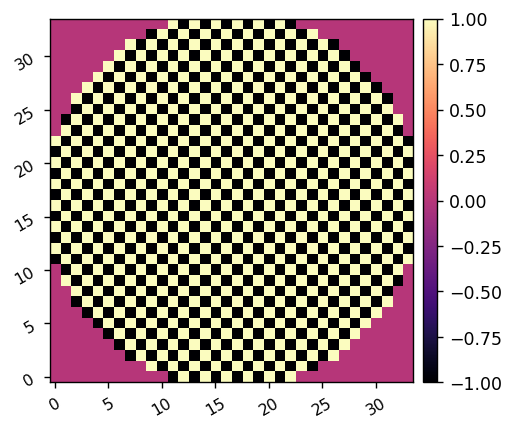

In [112]:
reload(scoobi.utils)
waffle_command = lina.utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

Set the ZWO exposure time to 5.00e-03s


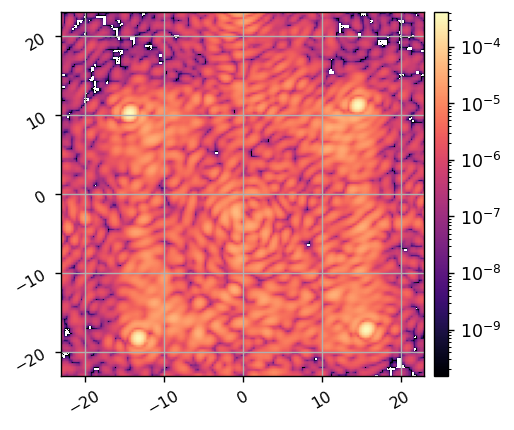

Set the ZWO exposure time to 5.00e-02s


In [114]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

original_texp = I.texp
I.set_zwo_exp_time(0.005, client0)

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

I.set_zwo_exp_time(original_texp, client0)


Centroids:
 [[ 31.44780164  15.20705652]
 [ 27.9160122  107.81671088]
 [121.93256889 111.07760677]
 [125.38764497  18.71594749]
 [ 31.44780164  15.20705652]]


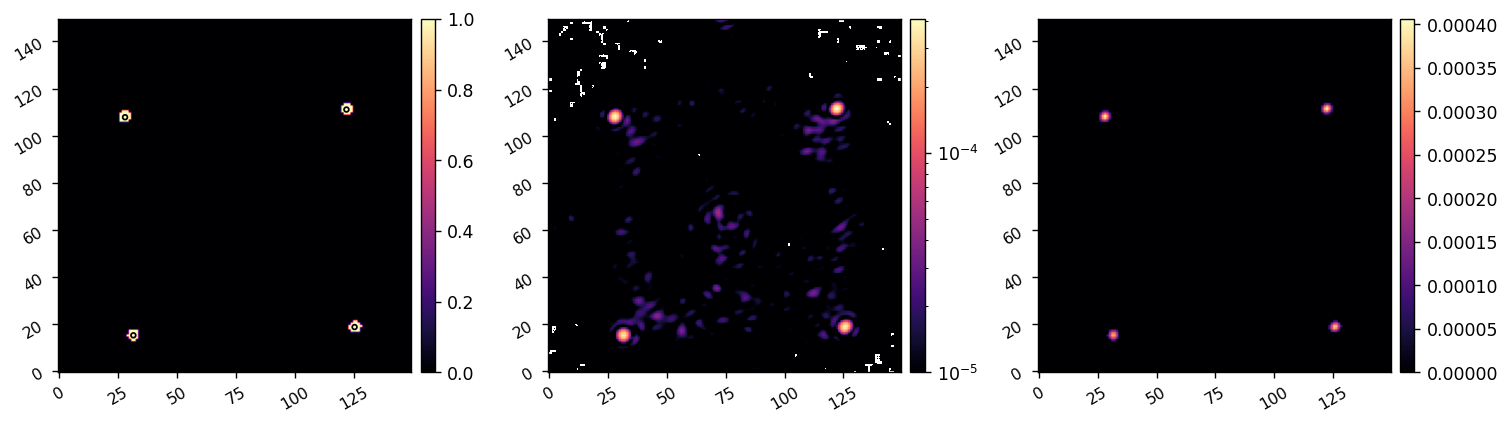

Angle:  87.88701671381205
Measured center in X:  76.7352466082997
Measured center in Y:  63.19007510150858
Required shift in X:  -2.0
Required shift in Y:  12.0


In [115]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=7e-5, r_thresh=16)

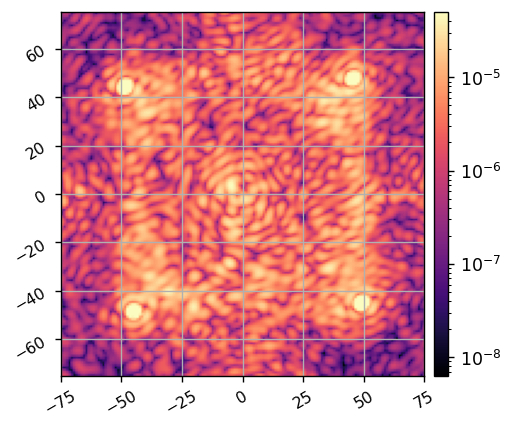

In [118]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift-1

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

Set the ZWO exposure time to 5.00e-02s
3.859655436590463e-06


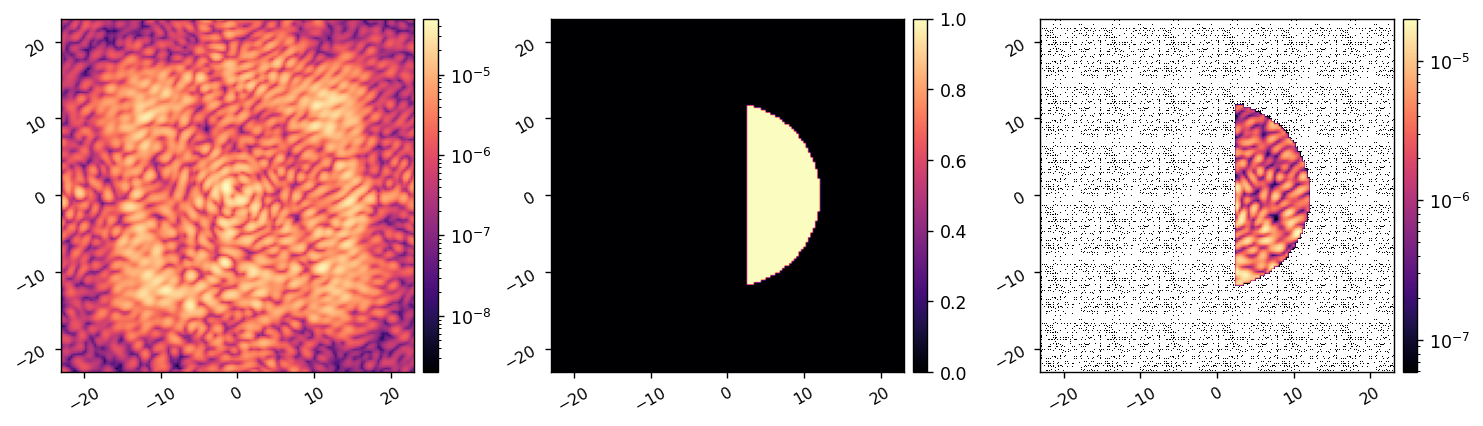

Saved data to:  data/20241029_ref_coro_im.fits


In [155]:
iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
I.set_zwo_exp_time(0.05, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'data/{today}_ref_coro_im.fits', ref_coro_im)

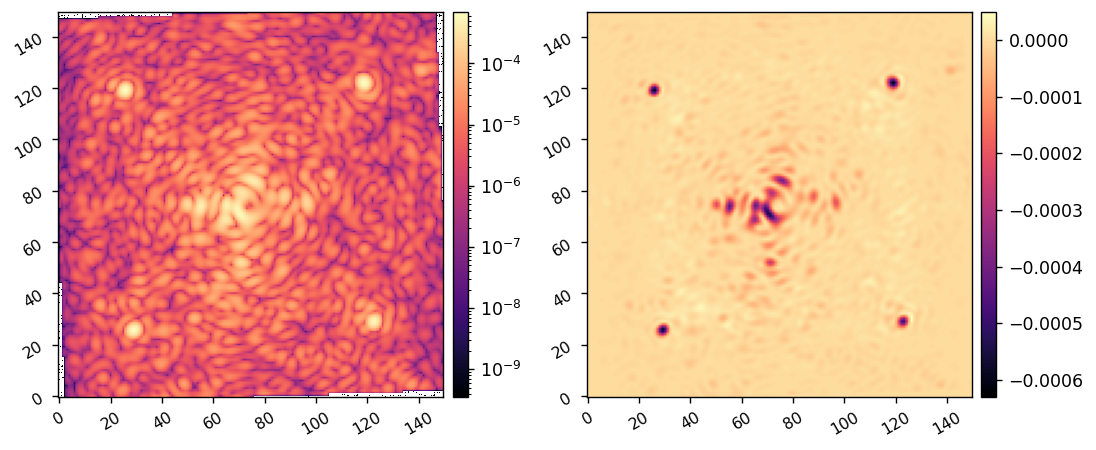

In [156]:
reload(rmad)
M = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0.1,0.0])*u.mm,
    lyot_shift=np.array([0,0.35])*u.mm,
)
M.WFE = WFE

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

M.set_dm(10e-9 * waffle_command)
M.setattr('use_vortex', True)
m_waffle_im = M.snap()

imshow2(m_waffle_im, waffle_im-m_waffle_im, lognorm1=True)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


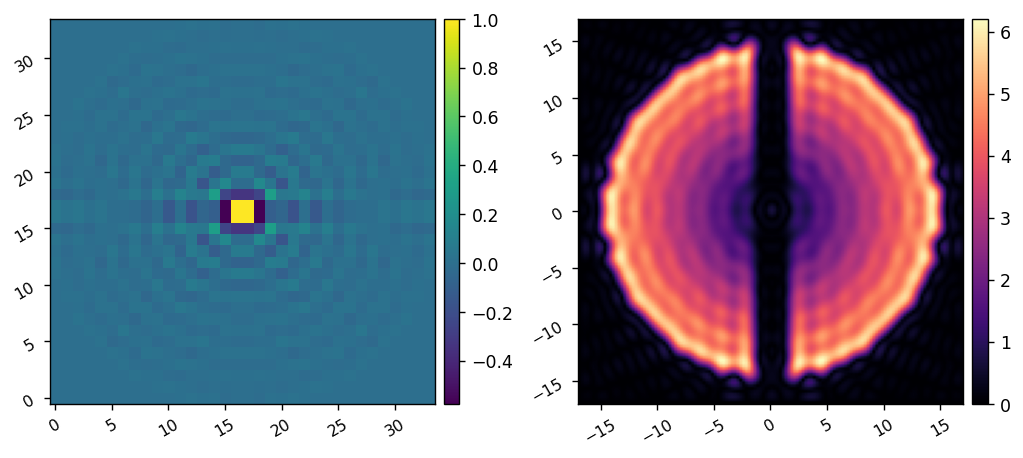

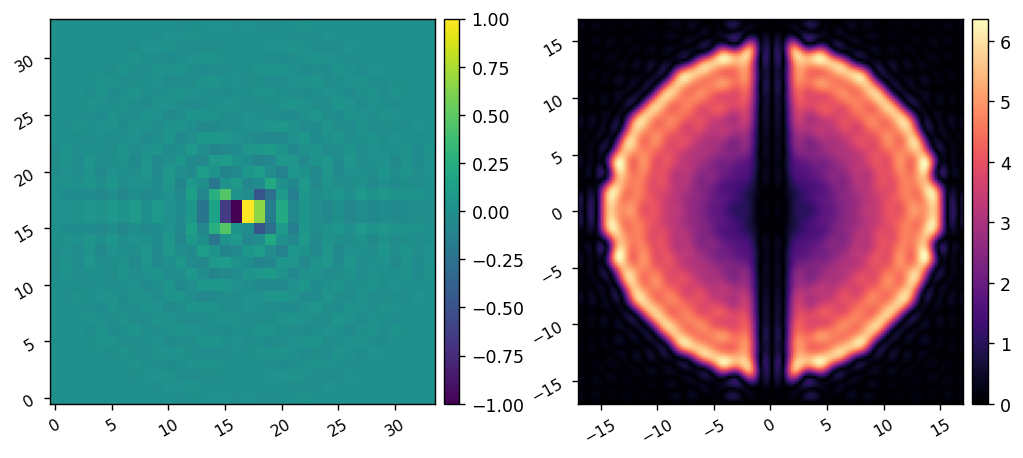

In [157]:
fourier_probes = lina.utils.create_fourier_probes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, 2, 14, 
                                                  rotation=0, 
                                                  fourier_sampling=0.75, 
                                                    nprobes=2,
                                                    plot=True,
                                                    use_weighting=True
                                                    )

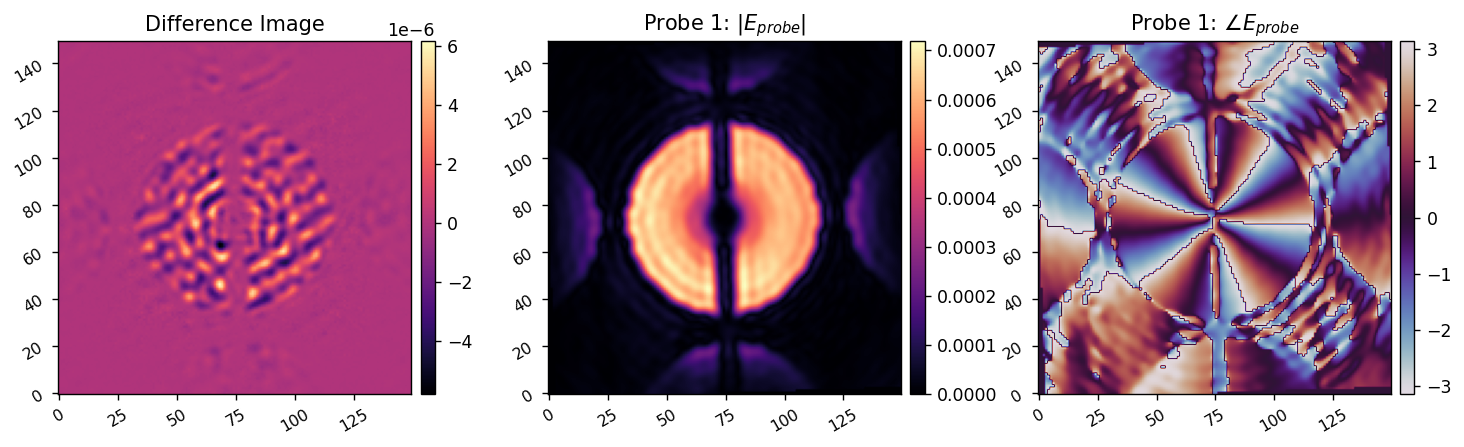

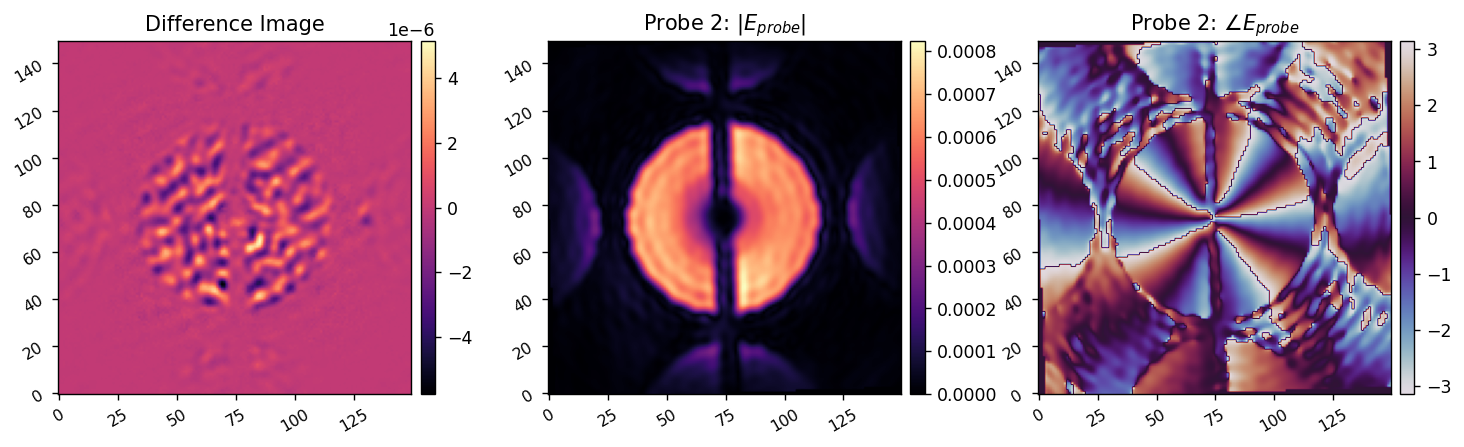

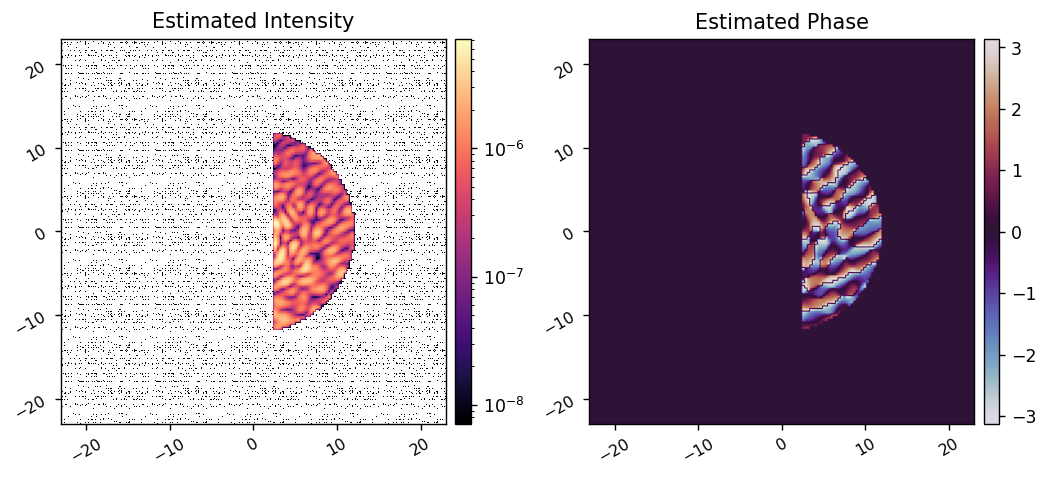

In [158]:
import lina.adefc as adefc
reload(adefc)

acts = xp.zeros(M.Nacts)

I.set_dm(rmad.acts_to_command(acts, M.dm_mask))
E_pwp = adefc.run_pwp(I, M, I.get_dm()[M.dm_mask], control_mask, fourier_probes, 5e-9, plot=True, reg_cond=1e-2)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

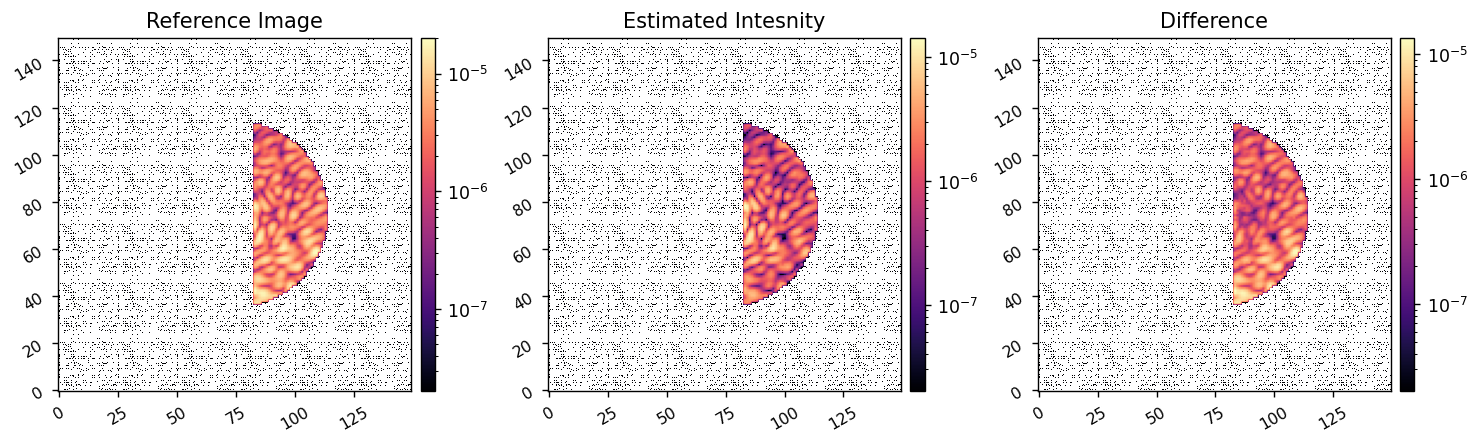

In [159]:
I_diff = ref_coro_im*control_mask - 2*I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(ref_coro_im*control_mask, 2*I_pwp, xp.abs(I_diff), 
        'Reference Image', 'Estimated Intesnity', 'Difference',
        lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

In [160]:
I.zero_dm()
all_ims = []
all_efs = []
all_commands = []


Running estimation algorithm ...


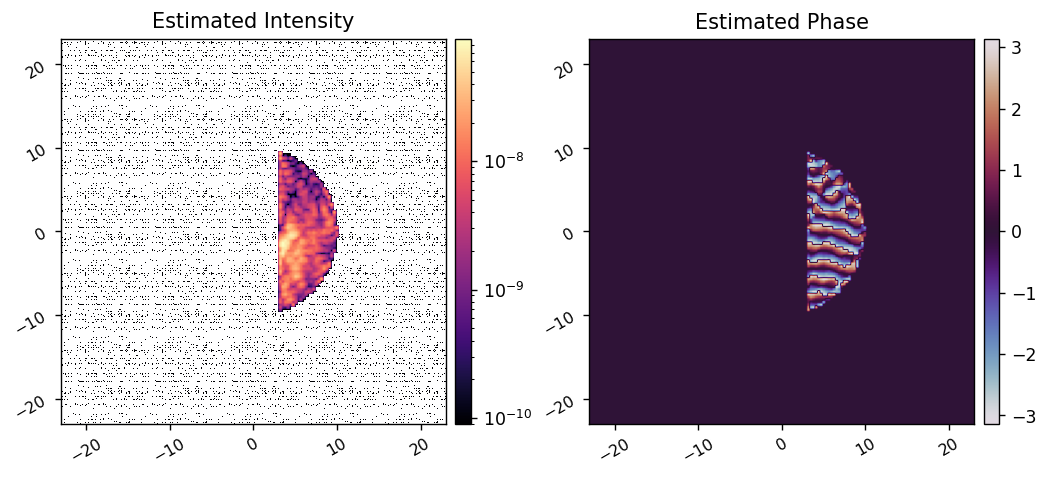

Computing EFC command with L-BFGS


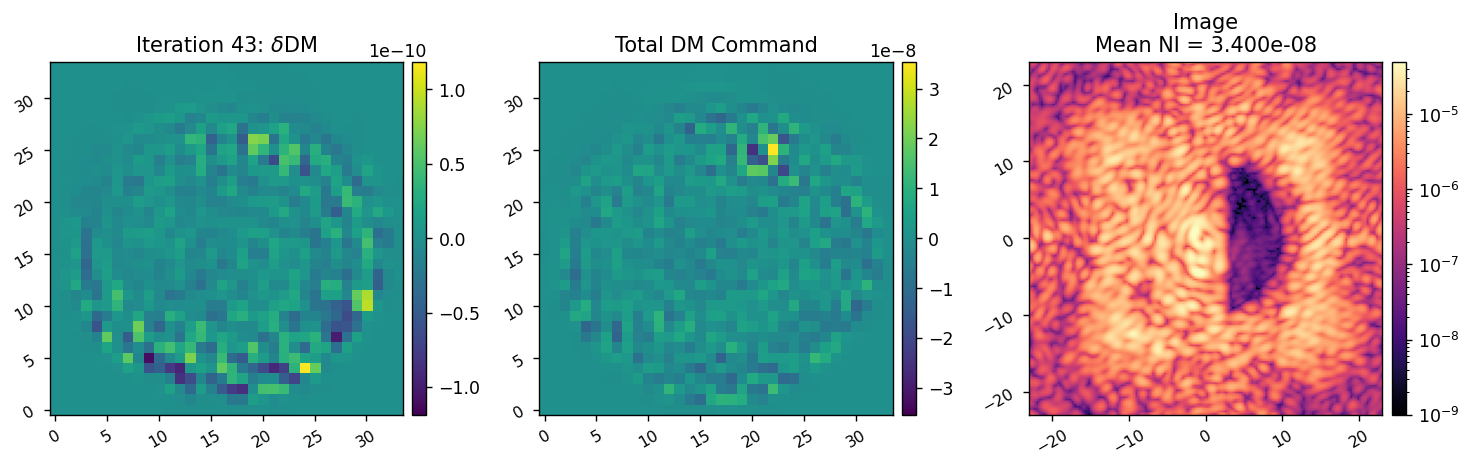

Running estimation algorithm ...


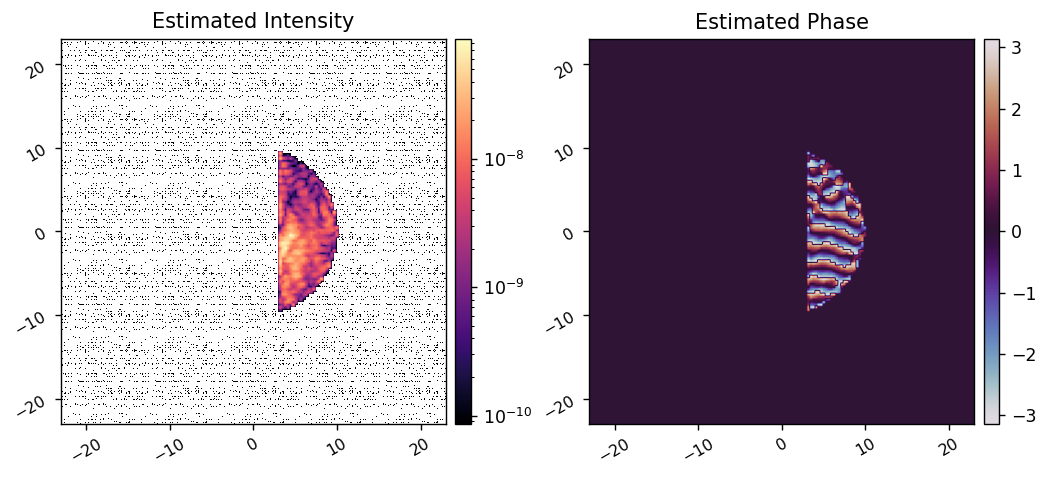

Computing EFC command with L-BFGS


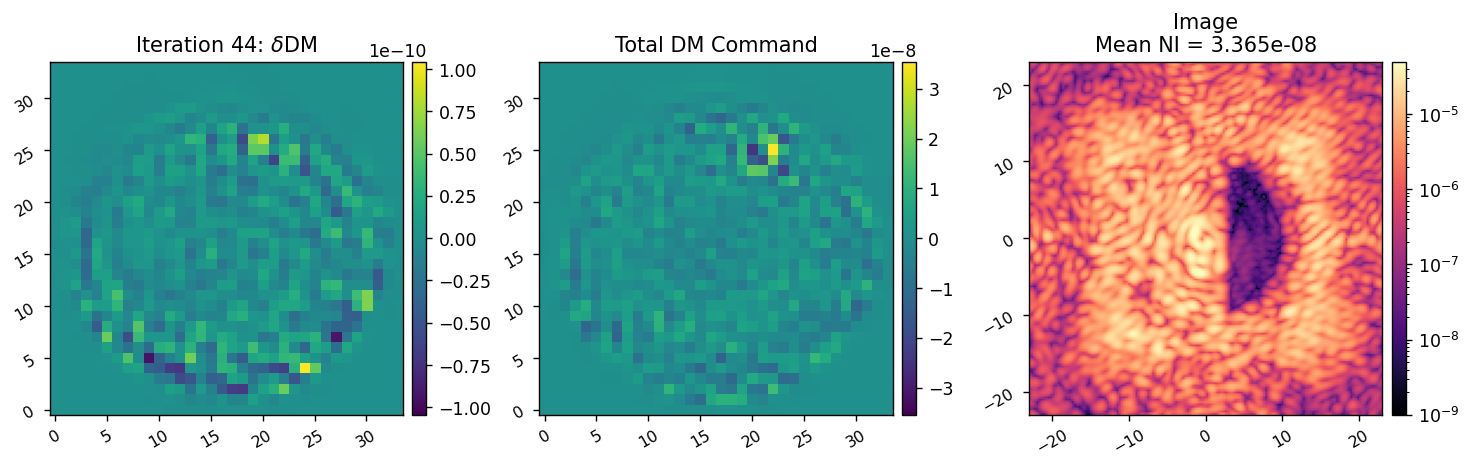

Running estimation algorithm ...


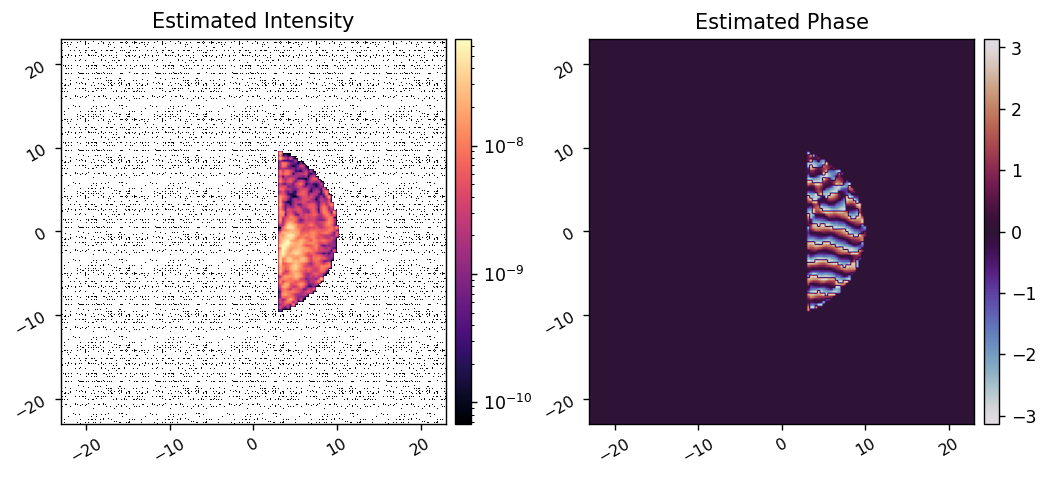

Computing EFC command with L-BFGS


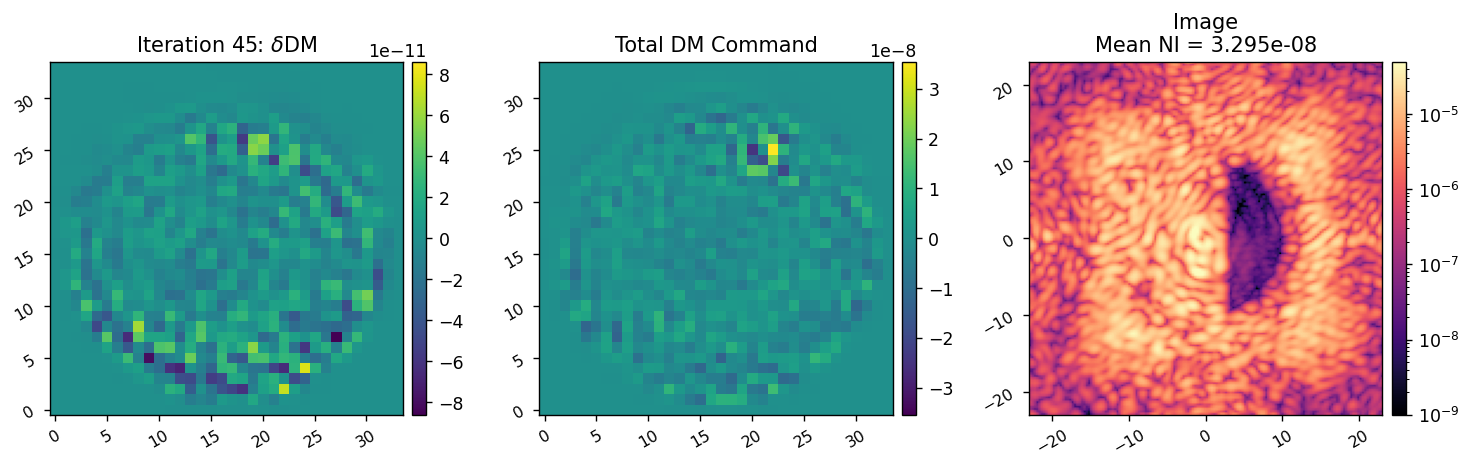

In [177]:
reload(rmad)
reload(adefc)

iwa = 2.5
owa = 12
iwa = 3
owa = 10
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

r_cond = 1e-1
r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

est_fun = adefc.run_pwp
est_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':5e-9,
    'probe_amp':4e-9,
    'probe_amp':3e-9,
    'probe_amp':2e-9,
    'probe_amp':1.5e-9,
    # 'probe_amp':1e-9,
    # 'probe_amp':0.75e-9, 
    'reg_cond':1e-3,
    'plot':False,
    'plot_est':True, 
}

I.NSCICAM = 20

all_ims, all_efs, all_commands = adefc.run(I, M, rmad.val_and_grad, control_mask, 
                                           est_fun, est_params, 
                                           Nitr=3, 
                                           reg_cond=r_cond,
                                           bfgs_tol=bfgs_tol,
                                           bfgs_opts=bfgs_opts,
                                           gain=1,
                                           all_ims=all_ims,
                                           all_efs=all_efs,
                                           all_commands=all_commands,
                                           )

In [179]:
lina.utils.save_fits(f'data/{today}_adefc_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'data/{today}_adefc_efs_r.fits', xp.array(all_efs).real)
lina.utils.save_fits(f'data/{today}_adefc_efs_i.fits', xp.array(all_efs).imag)
lina.utils.save_fits(f'data/{today}_adefc_commands.fits', xp.array(all_commands))

Saved data to:  data/20241029_adefc_ims.fits
Saved data to:  data/20241029_adefc_efs_r.fits
Saved data to:  data/20241029_adefc_efs_i.fits
Saved data to:  data/20241029_adefc_commands.fits


In [144]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [145]:
reload(scoobi)
scoobi.move_block_in(client0)

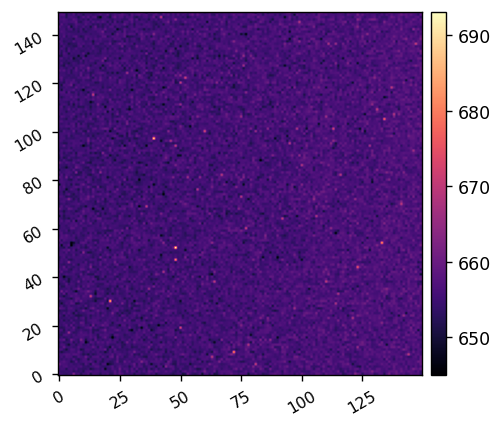

In [146]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [147]:
reload(scoobi)
scoobi.move_block_out(client0)

In [182]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


3.276383079474432e-08


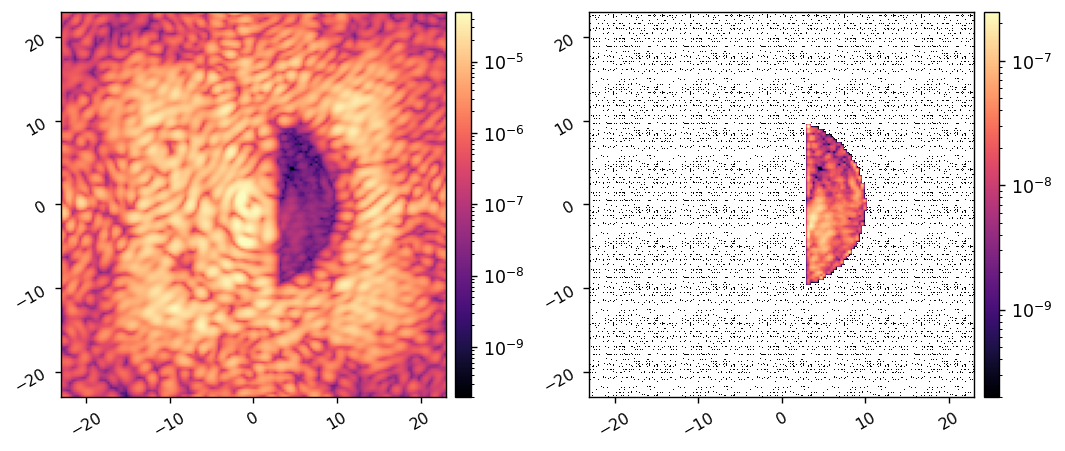

In [181]:
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

In [5]:
xp.concatenate([xp.array([ref_im]), ims]).shape

(46, 150, 150)

In [10]:
M = scoobm.MODEL()
iwa = 3
owa = 10
rotation = 0
control_mask = utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)


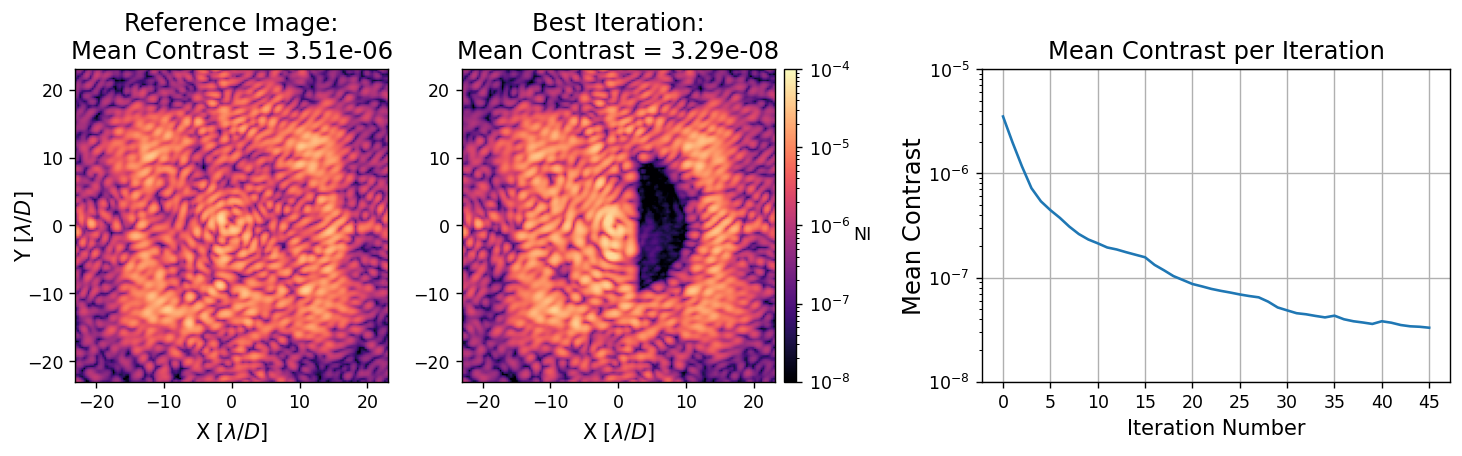

In [25]:
from adefc_vortex import imshows
reload(imshows)

date = 20241029
ref_im = utils.load_fits(f'data/{date}_ref_coro_im.fits')
ims = utils.load_fits(f'data/{date}_adefc_ims.fits')

data = {
    'images':xp.concatenate([xp.array([ref_im]), ims]),
    'control_mask': control_mask,
    'pixelscale':M.psf_pixelscale_lamDc,
}

imshows.plot_data(
    data, 
    imvmax=1e-4, imvmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 46, 5),
)
